In [59]:
%matplotlib inline

In [60]:
from os import environ
environ["CUDA_VISIBLE_DEVICES"] = "3"

from pathlib import Path
import torch
from hydra import initialize, compose
from hydra.utils import instantiate
from bliss.encoder import Encoder
from bliss.catalog import TileCatalog
from matplotlib import pyplot as plt

In [61]:
environ["BLISS_HOME"] = str(Path().resolve().parents[1])
with initialize(config_path="../../bliss/conf", version_base=None):
    cfg = compose("base_config")

encoder: Encoder = instantiate(cfg.encoder)
encoder.load_state_dict(torch.load("../../data/pretrained_models/clahed_logged_2percent.pt"))
encoder.eval()

simulator = instantiate(cfg.simulator)

In [62]:
loc_grid_size = 3
loc_replicates = 20
n = loc_grid_size * loc_replicates
n_sources = torch.zeros(n, 20, 20, dtype=torch.long)
n_sources[:, 10, 10] = 1
locs = torch.arange(loc_grid_size) / (loc_grid_size * 5)
locs = torch.stack([locs, torch.ones(loc_grid_size) * 0.5], dim=1)
locs = locs.view(loc_grid_size, 1, 1, 1, 1, 2).expand([-1, loc_replicates, 20, 20, 1, -1])
locs = locs.reshape(n, 20, 20, 1, 2)
true_catalog_dict = {
    "n_sources": n_sources,
    "source_type": torch.zeros(n, 20, 20, 1, 1, dtype=torch.long),
    "locs": locs,
    "star_fluxes": torch.ones(n, 20, 20, 1, 5) * 5,
    "galaxy_fluxes": torch.ones(n, 20, 20, 1, 5),
}
true_catalog = TileCatalog(4, true_catalog_dict)


In [63]:
rcfs, rcf_indices = simulator.randomized_image_ids(true_catalog.n_sources.size(0))


In [64]:
image, background, _, _ = simulator.simulate_image(true_catalog, rcfs, rcf_indices)

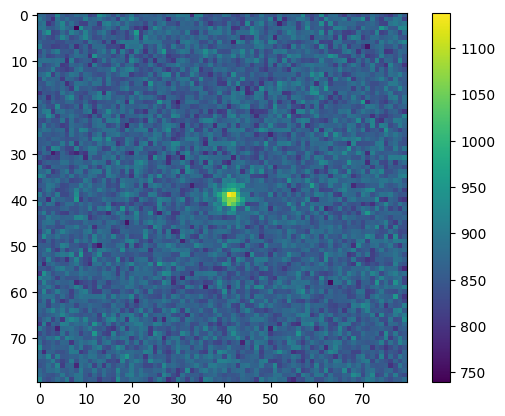

In [65]:
plt.imshow(image[8, 2].numpy())
plt.colorbar()

In [66]:
import gc
gc.collect()
torch.cuda.empty_cache()
torch.cuda.memory_allocated() / 1e9

0.026098688

In [67]:
encoder.cuda()
image = image.cuda()
background = background.cuda()

In [68]:
batch = {"images": image, "background": background}
est_cat, pred = encoder.predict_step(batch, 0, 0).values()

In [69]:
est_cat.n_sources.sum(1).sum(1)

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0')

tensor(0.6438)

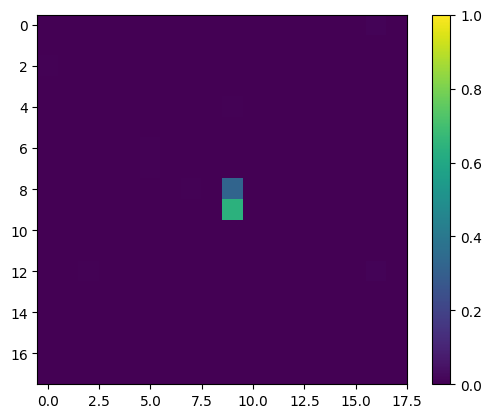

In [70]:
on_prob = pred["on_prob"].probs[:, :, :, 1].cpu()
on_prob = on_prob.view(loc_grid_size, loc_replicates, 18, 18).mean(1)[0]
plt.imshow(on_prob, vmin=0, vmax=1)
plt.colorbar()
on_prob.max()

In [71]:
torch.no_grad()

In [72]:
joint_cats = encoder.sample(batch)

In [73]:
marginal_cats = encoder.sample(batch, cat_type="marginal")

In [74]:
joint_cats["n_sources"].sum(1).sum(1)[:20]

tensor([1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1],
       device='cuda:0')

In [75]:
marginal_cats["n_sources"].sum(1).sum(1)[:20]

tensor([2, 1, 0, 1, 1, 2, 1, 2, 0, 1, 0, 1, 1, 1, 1, 2, 2, 1, 1, 1],
       device='cuda:0')

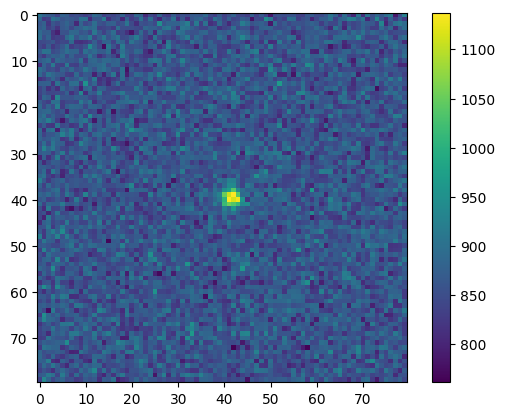

In [77]:
plt.imshow(image[2, 2].cpu())
plt.colorbar()